# <h1>**Table of Contents**<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Clean-housing-data" data-toc-modified-id="Clean-housing-data-1">Clean housing data</a></span><ul class="toc-item"><li><span><a href="#Read-data-from-all-CSV-files" data-toc-modified-id="Read-data-from-all-CSV-files-1.1">Read data from all CSV files</a></span></li><li><span><a href="#Merge-all-CSV-into-a-single-sheet" data-toc-modified-id="Merge-all-CSV-into-a-single-sheet-1.2">Merge all CSV into a single sheet</a></span><ul class="toc-item"><li><span><a href="#Find-if-there-are-duplicates" data-toc-modified-id="Find-if-there-are-duplicates-1.2.1">Find if there are duplicates</a></span></li><li><span><a href="#Clean-column-names" data-toc-modified-id="Clean-column-names-1.2.2">Clean column names</a></span></li><li><span><a href="#Drop-unnecessary-columns" data-toc-modified-id="Drop-unnecessary-columns-1.2.3">Drop unnecessary columns</a></span></li><li><span><a href="#Find-and-fill-missing-values" data-toc-modified-id="Find-and-fill-missing-values-1.2.4">Find and fill missing values</a></span></li></ul></li><li><span><a href="#Explore-distribution-of-numeric-columns" data-toc-modified-id="Explore-distribution-of-numeric-columns-1.3">Explore distribution of numeric columns</a></span><ul class="toc-item"><li><span><a href="#Build-statistical-filters-to-remove-outliers" data-toc-modified-id="Build-statistical-filters-to-remove-outliers-1.3.1">Build statistical filters to remove outliers</a></span><ul class="toc-item"><li><span><a href="#6-sigma-filter" data-toc-modified-id="6-sigma-filter-1.3.1.1">6 sigma filter</a></span></li><li><span><a href="#IQR-filter" data-toc-modified-id="IQR-filter-1.3.1.2">IQR filter</a></span></li></ul></li><li><span><a href="#Filter-columns-using-both-filters-and-compare" data-toc-modified-id="Filter-columns-using-both-filters-and-compare-1.3.2">Filter columns using both filters and compare</a></span></li></ul></li><li><span><a href="#Write-cleaned,-appended-table-to-disk" data-toc-modified-id="Write-cleaned,-appended-table-to-disk-1.4">Write cleaned, appended table to disk</a></span></li></ul></li></ul></div>

# Clean housing data
In this notebook, we download housing data from a popular MLS website, merge, clean, filter and prepare it for subsequent spatial and statistical analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Read data from all CSV files

In [2]:
csv1_path = 'data/price1.csv'
csv2_path = 'data/price2.csv'
csv3_path = 'data/price3.csv'

prop_df1 = pd.read_csv(csv1_path)
prop_df2 = pd.read_csv(csv2_path)
prop_df3 = pd.read_csv(csv3_path)
prop_df1.head(3)

,SALE TYPE,SOLD DATE,PROPERTY TYPE,CITY,STATE,ZIP,PRICE,BEDS,BATHS,LOCATION,...,HOA/MONTH,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,MLS Listing,NaN,Single Family Residential,Portland,OR,97211.0,27500.0,0.0,1.0,RODGER'S MARINA,...,NaN,Active,NaN,NaN,RMLS,18567126,N,Y,45.604756,-122.624335
1,MLS Listing,NaN,Vacant Land,Portland,OR,97210.0,30000.0,NaN,NaN,"Portland West, Raleigh Hills",...,NaN,Active,NaN,NaN,RMLS,18118897,N,Y,45.522837,-122.733173
2,MLS Listing,NaN,Vacant Land,Portland,OR,97220.0,34777.0,NaN,NaN,Portland Northeast,...,NaN,Active,NaN,NaN,RMLS,18454531,N,Y,45.554321,-122.553849


In [3]:
(prop_df1.shape, prop_df2.shape, prop_df3.shape)

((3716, 25), (387, 25), (133, 25))

## Merge all CSV into a single sheet

In [4]:
prop_df = prop_df1.append(prop_df2)
prop_df = prop_df.append(prop_df3)
prop_df.shape

(4236, 25)

### Find if there are duplicates

In [5]:
prop_dup_index = prop_df.duplicated(['MLS#'])
prop_dup = prop_df[prop_dup_index]
prop_dup.shape

(209, 25)

In [6]:
prop_df.drop_duplicates(subset=['MLS#'], inplace=True)
prop_df.shape

(4027, 25)

### Clean column names
Column names contain illegal characters. Let us rename them

In [16]:
prop_df.columns

Index(['SALE TYPE', 'PROPERTY TYPE', 'CITY', 'STATE', 'ZIP', 'PRICE', 'BEDS',
       'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT',
       'DAYS ON MARKET', 'PRICE PER SQFT', 'HOA PER MONTH', 'STATUS', 'SOURCE',
       'MLS', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [17]:
prop_df.rename(index=str, columns={'$/SQUARE FEET':'PRICE PER SQFT',
                                  'HOA/MONTH':'HOA PER MONTH',
                                  'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)':'URL',
                                  'MLS#':'MLS'}, inplace=True)
prop_df.columns

Index(['SALE TYPE', 'PROPERTY TYPE', 'CITY', 'STATE', 'ZIP', 'PRICE', 'BEDS',
       'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT',
       'DAYS ON MARKET', 'PRICE PER SQFT', 'HOA PER MONTH', 'STATUS', 'SOURCE',
       'MLS', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

### Видалити непотрібні стовпці ¶
Хоча корисно мати багато можливостей (стовпців) у  наборі даних, важливо також відмовитися від тих, які мають високу кореляцію з існуючим полем або похідною від одного або полів, які ми ніколи не будемо використовувати. Далі ми видаляємо поля, які ніколи не будемо використовувати у цьому аналізі.

In [15]:
prop_df.drop(columns=['SOLD DATE','NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME',
                     'FAVORITE', 'INTERESTED'], inplace=True)

KeyError: "['SOLD DATE' 'NEXT OPEN HOUSE START TIME' 'NEXT OPEN HOUSE END TIME'\n 'FAVORITE' 'INTERESTED'] not found in axis"

In [18]:
prop_df.columns

Index(['SALE TYPE', 'PROPERTY TYPE', 'CITY', 'STATE', 'ZIP', 'PRICE', 'BEDS',
       'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT',
       'DAYS ON MARKET', 'PRICE PER SQFT', 'HOA PER MONTH', 'STATUS', 'SOURCE',
       'MLS', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

### Find and fill missing values
Missing values in certain columns are critical - `beds`, `bath`, `price`, `latitude`, `longitude`. We will drop these rows. Missing values in remaining columns are not so critical, we will fill them with `0` or average values.

Before we fill, let us explore the histograms of numerical columns. With pandas, this can be accomplished with a single command as shown below:

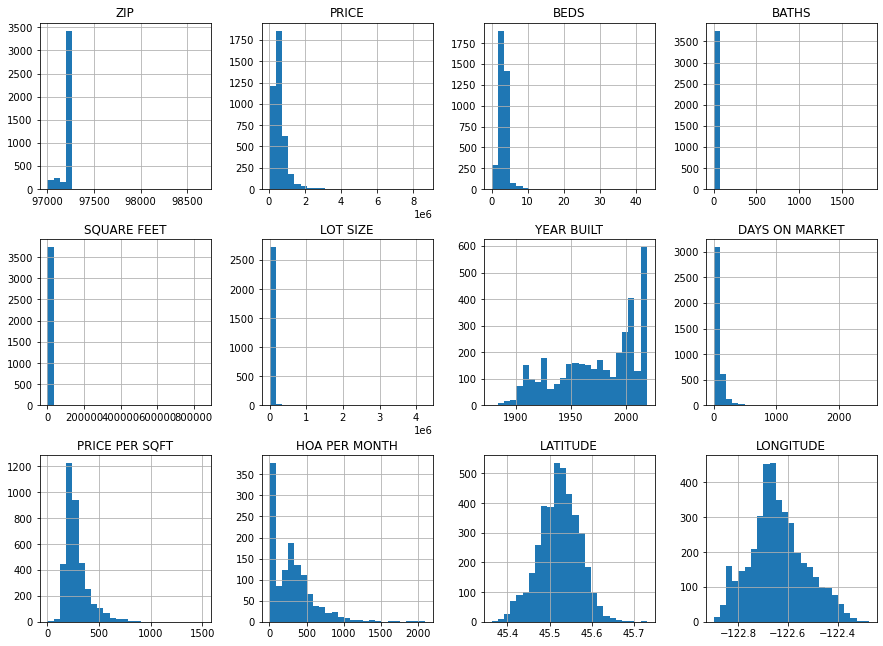

In [19]:
# explore distribution of numeric columns
ax_list = prop_df.hist(bins=25, layout=(4,4), figsize=(15,15))

In [20]:
# drop rows with missing values in critical columns
prop_df_nona = prop_df.dropna(axis=0, how='any', # if any of these cols are empty, remove row
                              subset=['BEDS','BATHS', 'PRICE', 'YEAR BUILT', 'LATITUDE','LONGITUDE'])
prop_df_nona.shape

(3653, 20)

Let us impute for missing values using different strategies for different columns.

In [21]:
prop_df_nona['HOA PER MONTH'].fillna(value=0, inplace=True)
prop_df_nona['LOT SIZE'].fillna(value=prop_df_nona['LOT SIZE'].median(), inplace=True)
prop_df_nona['PRICE PER SQFT'].fillna(value=prop_df_nona['PRICE PER SQFT'].median(), inplace=True)
prop_df_nona['SQUARE FEET'].fillna(value=prop_df_nona['SQUARE FEET'].median(), inplace=True)
prop_df_nona['YEAR BUILT'].fillna(value=prop_df_nona['YEAR BUILT'].mode(), inplace=True)
prop_df_nona['ZIP'].fillna(value=prop_df_nona['SQUARE FEET'].mode(), inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


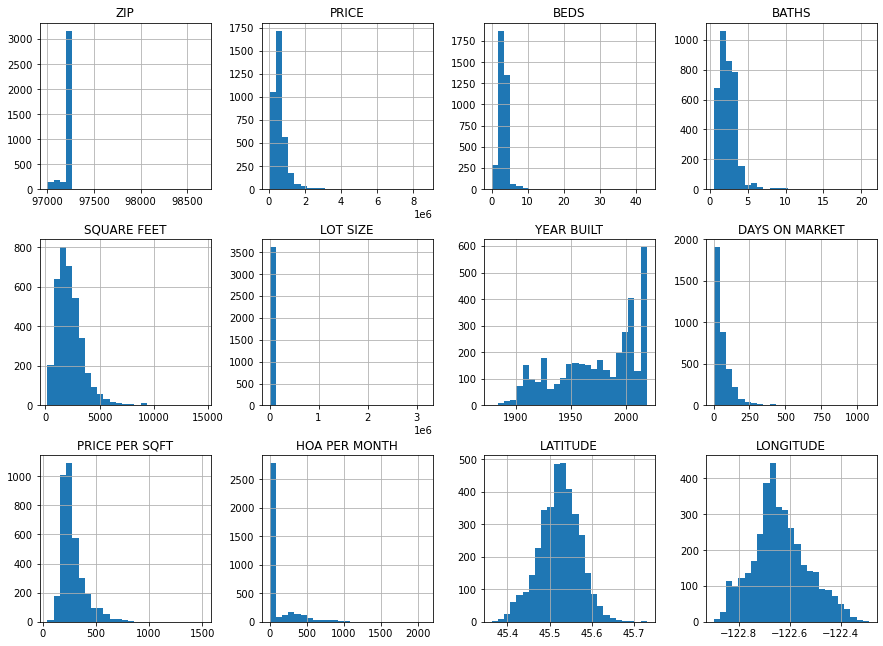

In [22]:
# explore distribution of numeric columns
ax_list = prop_df_nona.hist(bins=25, layout=(4,4), figsize=(15,15))

## Explore distribution of numeric columns

As can be seen from histogram, some numeric columns are heavily sqewed by outliers. Let us pull up statistics for each of these columns

In [23]:
prop_df_nona.describe().round(3)

,ZIP,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,PRICE PER SQFT,HOA PER MONTH,LATITUDE,LONGITUDE
count,3653.000,3653.000,3653.000,3653.000,3653.000,3653.000,3653.000,3653.000,3653.000,3653.000,3653.000,3653.000
mean,97210.091,609851.635,3.316,2.428,2291.079,13448.155,1973.970,62.268,281.446,105.865,45.523,-122.638
std,93.873,458104.003,1.762,1.340,1342.049,72390.700,36.279,72.488,118.235,223.111,0.048,0.108
min,97002.000,35000.000,0.000,0.500,212.000,25.000,1878.000,1.000,44.000,0.000,45.363,-122.899
25%,97206.000,359900.000,2.000,2.000,1400.000,5227.000,1948.000,15.000,206.000,0.000,45.491,-122.704
50%,97217.000,495000.000,3.000,2.500,2062.000,6969.000,1980.000,42.000,251.000,0.000,45.524,-122.651
75%,97229.000,699934.000,4.000,3.000,2862.000,8712.000,2006.000,84.000,321.000,74.000,45.554,-122.573
max,98664.000,8650000.000,43.000,21.000,14500.000,3167247.000,2019.000,1080.000,1505.000,2091.000,45.730,-122.290


### Build statistical filters to remove outliers
In this segment, we build $6\sigma$ and Inter Quartile Range (`IQR`) filters to remove outliers from our dataset.

#### 6 sigma filter
![](https://cdn-images-1.medium.com/max/800/1*3tcjd64JtWcl37MSidL7Cg.png)
Statistically, about `99.5%` of data falls within $\pm 3 \sigma$ from $\mu$ (mean). Thus, for fairly normally distributed data, $6\sigma$ filter yields a good resultant dataset.

#### IQR filter
![](https://cdn-images-1.medium.com/max/800/1*igFam1Zx-r4boy1T_5LKlw.png)
Howerver, certain columns such as `BEDS`, `LOT SIZE` are heavily sqewed. For such, the Inter Quartile Range filter (which uses median as a measure of centrality unlike 6sigma which uses mean) yields a robust filter as it is unaffected by outliers like the 6 sigma filter. 

In [34]:
def six_sigma_filter(df, column):
    sigma = df[column].std()
    mu = df[column].mean()
    three_sigma = [mu-(3*sigma), mu+(3*sigma)]
    #print("Column:{}, Mean:{}, Sigma:{}, 3sigma_range: {}:{}".format(column,mu.round(3),
                                                                       #sigma.round(3),
                                                                       #three_sigma[0].round(2),
                                                                       #three_sigma[1].round(2)))
    
    # filter
    df_to_keep = df[(df[column] > three_sigma[0]) & (df[column] < three_sigma[1])]
    
    # prints
    num_rows_dropped = prop_df.shape[0] - df_to_keep.shape[0]
    print("Number of rows dropped: " + str(num_rows_dropped))
    
    return df_to_keep

In [35]:
def iqr_filter(df, column):
    med = df[column].median()
    p_25 = df[column].quantile(q=0.25)
    p_75 = df[column].quantile(q=0.75)
    
    # find valid range
    iqr_range = [med-(2*p_25), med+(2*p_75)]
    #print("Column: {}, Median:{}, 25%:{}, 75%:{}, IQR:{}:{}".format(column,med,
                                                                    #p_25,p_75,
                                                                    #iqr_range[0].round(2),
                                                                    #iqr_range[1].round(2)))
    
    # filter
    df_to_keep = df[(df[column] > iqr_range[0]) & (df[column] < iqr_range[1])]
    
    #prints
    num_rows_dropped = prop_df.shape[0] - df_to_keep.shape[0]
    print("Number of rows dropped: " + str(num_rows_dropped))
    
    return df_to_keep

### Filter columns using both filters and compare

In [36]:
prop_df2 = six_sigma_filter(prop_df_nona, 'BATHS')

Number of rows dropped: 422


In [37]:
prop_df2_iqr = iqr_filter(prop_df_nona, 'BATHS')

Number of rows dropped: 396


In [38]:
prop_df4 = six_sigma_filter(prop_df2, 'BEDS')

Number of rows dropped: 459


In [39]:
prop_df4_iqr = iqr_filter(prop_df2_iqr, 'BEDS')

Number of rows dropped: 403


In [40]:
(prop_df4.shape, prop_df4_iqr.shape)

((3568, 20), (3624, 20))

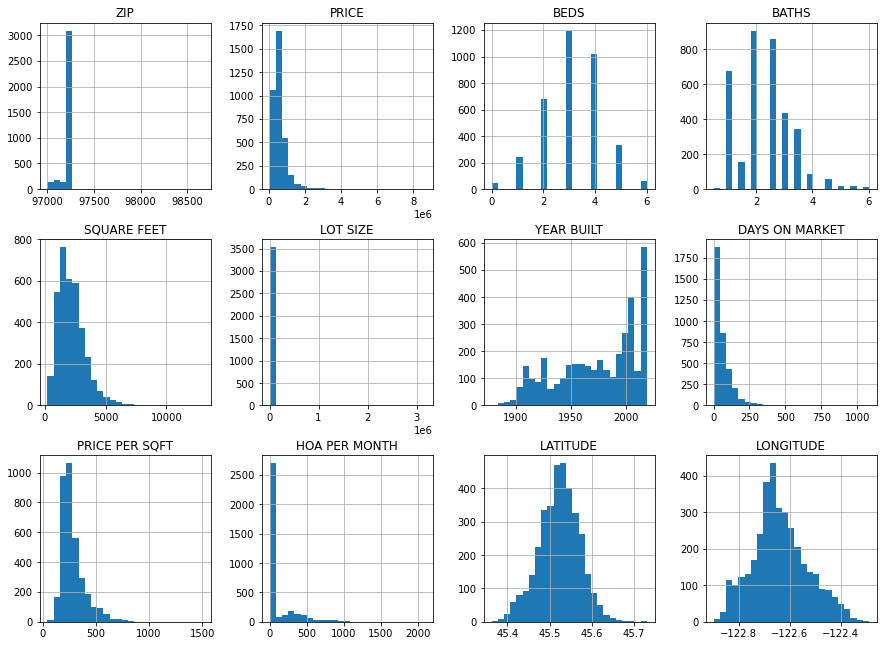

In [41]:
ax_list = prop_df4.hist(bins=25, layout=(4,4), figsize=(15,15))

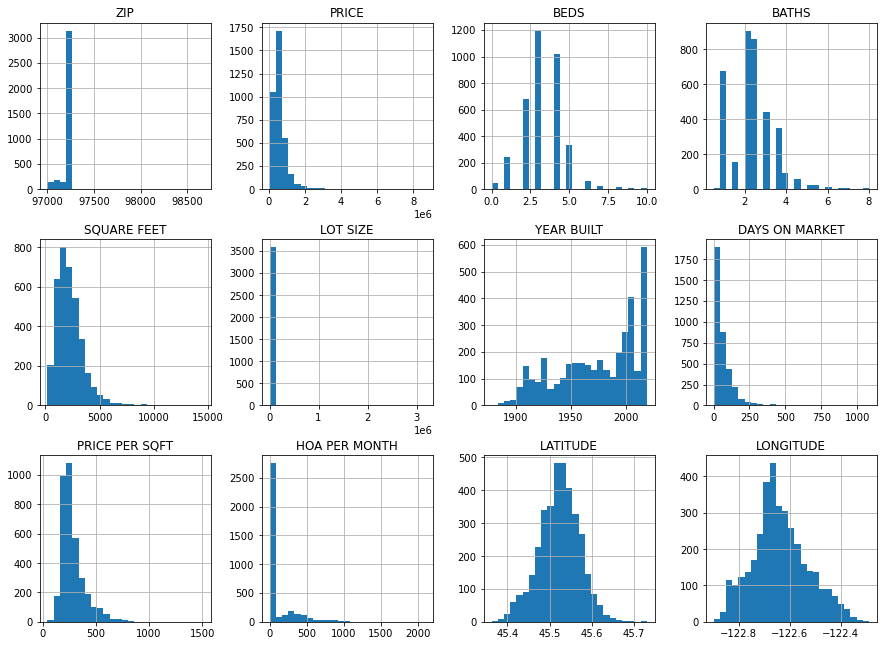

In [42]:
ax_list = prop_df4_iqr.hist(bins=25, layout=(4,4), figsize=(15,15))

## Write cleaned, appended table to disk

The `IQR` filter yields a better result in our case as the resulting histograms of numeric columns show a nice normal distribution. We proceed with this dataset and write that to disk.

In [43]:
prop_df4_iqr.to_csv('data/houses_for_sale_filtered.csv')